In [1]:
import sys
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

/home/allen/anaconda3/envs/dlcv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
config = {
    "device" :  "cuda" if torch.cuda.is_available() else "cpu",
    "c_noise" : 100,
    "feature_dim" : 64,
}
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, (nn.BatchNorm2d, nn.LayerNorm)):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.)
        
def load_checkpoint(checkpoint_path, device='cpu'):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    return checkpoint["model_state_dict"], checkpoint["optimizer_state_dict"]

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(7777)

In [18]:
class DCGAN_Generator(nn.Module):
    def __init__(self, c_noise, feature_dim, c_img) -> None:
        super().__init__()
        self.project = nn.Sequential(
            nn.ConvTranspose2d(c_noise, feature_dim*16, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(feature_dim*16),
            nn.ReLU(True)
        )
        self.conv = nn.Sequential(
            self.dconv_bn_relu(feature_dim*16, feature_dim*8),
            self.dconv_bn_relu(feature_dim*8, feature_dim*4),
            self.dconv_bn_relu(feature_dim*4, feature_dim*2)
        )
        self.last = nn.Sequential(
            nn.ConvTranspose2d(feature_dim*2, c_img, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh() 
        )
        self.apply(weights_init)

    def dconv_bn_relu(self, in_dim, out_dim):
        return nn.Sequential(
            nn.ConvTranspose2d(in_dim, out_dim, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        x1 = self.project(x)
        x2 = self.conv(x1)
        # print("Generator x1 {} x2 {}".format(x1.shape, x2.shape))
        return self.last(x2)
class DCGAN_Discriminator(nn.Module):
    def __init__(self, feature_dim, c_img) -> None:
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(c_img, feature_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            self.conv_bn_lrelu(feature_dim, feature_dim*2),
            self.conv_bn_lrelu(feature_dim*2, feature_dim*4),
            self.conv_bn_lrelu(feature_dim*4, feature_dim*8),
            nn.Conv2d(feature_dim*8, 1, kernel_size=4, bias=False),
            nn.Sigmoid()
        )
        self.apply(weights_init)

    def conv_bn_lrelu(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
    def forward(self, x):
        return self.disc(x).squeeze()
        

In [19]:

class SNGAN_Generator(nn.Module):
    def __init__(self, c_noise, feature_dim, c_img) -> None:
        super().__init__()
        self.project = nn.Sequential(
            nn.ConvTranspose2d(c_noise, feature_dim*16, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(feature_dim*16),
            nn.ReLU(True)
        )
        self.conv = nn.Sequential(
            self.dconv_bn_relu(feature_dim*16, feature_dim*8),
            self.dconv_bn_relu(feature_dim*8, feature_dim*4),
            self.dconv_bn_relu(feature_dim*4, feature_dim*2)
        )
        self.last = nn.Sequential(
            nn.ConvTranspose2d(feature_dim*2, c_img, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh() 
        )
        self.apply(weights_init)

    def dconv_bn_relu(self, in_dim, out_dim):
        return nn.Sequential(
            nn.ConvTranspose2d(in_dim, out_dim, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        x1 = self.project(x)
        x2 = self.conv(x1)
        return self.last(x2)

class SNGAN_Discriminator(nn.Module):
    def __init__(self, feature_dim, c_img) -> None:
        super().__init__()
        self.disc = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(c_img, feature_dim, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2),
            self.conv_bn_lrelu(feature_dim, feature_dim*2, feature_dim//4, feature_dim//4),
            self.conv_bn_lrelu(feature_dim*2, feature_dim*4, feature_dim//8, feature_dim//8),
            self.conv_bn_lrelu(feature_dim*4, feature_dim*8, feature_dim//16, feature_dim//16),
            nn.utils.spectral_norm(nn.Conv2d(feature_dim*8, 1, kernel_size=4, bias=False)),
        )
        self.apply(weights_init)

    def conv_bn_lrelu(self, in_dim, out_dim, h, w):
        return nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_dim, out_dim, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.LayerNorm([out_dim, h, w]),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
    def forward(self, x):
        return self.disc(x).squeeze()

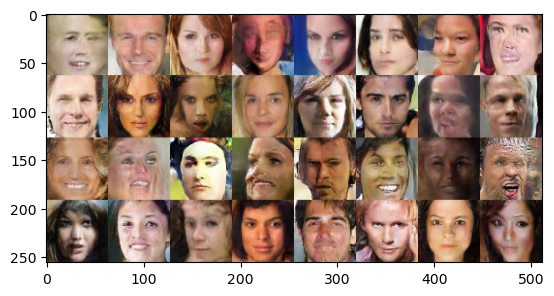

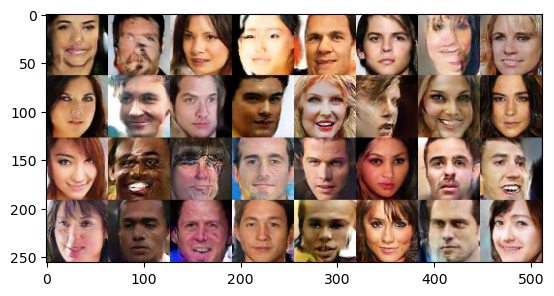

In [20]:
dcgan = DCGAN_Generator(c_noise=config["c_noise"], feature_dim=config["feature_dim"], c_img=3).to(config["device"])
sngan = SNGAN_Generator(c_noise=config["c_noise"], feature_dim=config["feature_dim"], c_img=3).to(config["device"])
dccheck = load_checkpoint("/data/allen/hw2model/dcgan_G_ep200.pth", device=config["device"])[0]
sncheck = load_checkpoint("/data/allen/hw2model/hw2_1_G.pth", device=config["device"])[0]
dcgan.load_state_dict(dccheck)
sngan.load_state_dict(sncheck)
z_samples = torch.randn(32, config["c_noise"], 1, 1, device=config["device"]) #fix sample used
with torch.no_grad():
    dcimg, snimg = dcgan(z_samples), sngan(z_samples)
    imshow(torchvision.utils.make_grid(dcimg.cpu(), padding=0))
    imshow(torchvision.utils.make_grid(snimg.cpu(), padding=0))
    